# Projet de visualisation : Baby names

Membres de l'équipe:

- Membre 1:**Ouhiba Aymen**  
- Membre 2:**Garra Nohalia**  
- Membre 3: **Vu Julien**
- Membre 4: **Wande Wula Alfred**
- Membre 5: **Mbathe Mekontchou Paul**

# Contexte général
Ce notebook propose une analyse exploratoire des prénoms donnés aux enfants en France entre 1900 et 2020, à partir des données ouvertes de l’INSEE. L’objectif est de comprendre comment les préférences en matière de prénoms ont évolué dans le temps, selon le sexe, et à travers les régions françaises.

# Objectifs
Nous avons structuré notre analyse en plusieurs étapes complémentaires :

**Visualisation temporelle globale**

→ Identifier les prénoms les plus donnés sur toute la période et suivre leur évolution annuelle (ex : Marie, Jean, Pierre...).

**Exploration interactive avec Altair**

→ Permettre une navigation fluide et dynamique dans les courbes d’évolution, avec survol interactif pour lire les valeurs exactes.
  
**Visualisation géographique**

→ Générer une carte de France indiquant le prénom le plus populaire par département, révélant les spécificités régionales et culturelles.

**Analyse locale par département**

→ Offrir un focus interactif sur un département choisi, pour explorer son propre top 5 des prénoms.

**Analyse par sexe**

→ Comparer les prénoms féminins et masculins les plus populaires, puis visualiser leur évolution respective dans le temps.



__Ce travail s’inscrit dans une démarche de data storytelling visant à rendre les données sociétales accessibles, visuelles et interprétables. Les visualisations proposées permettent d’illustrer comment les prénoms, reflet intime de chaque époque, constituent aussi un marqueur culturel et géographique fort.__


In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from tabulate import tabulate
import ipywidgets as widgets
from IPython.display import display, clear_output

####  phase 0 : Préparation

In [2]:
# Chargement des données (séparateur ;)
df = pd.read_csv("dpt2020.csv", sep=';')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3727553 entries, 0 to 3727552
Data columns (total 5 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   sexe      int64 
 1   preusuel  object
 2   annais    object
 3   dpt       object
 4   nombre    int64 
dtypes: int64(2), object(3)
memory usage: 142.2+ MB


In [4]:
# Renommage et nettoyage
df = df.rename(columns={
    'annais': 'year',
    'preusuel': 'name',
    'sexe': 'sex',
    'nombre': 'count',
    'dpt': 'dpt'
})

In [5]:
df.head()

sex            name  year dpt  count
0    1  _PRENOMS_RARES  1900  02      7
1    1  _PRENOMS_RARES  1900  04      9
2    1  _PRENOMS_RARES  1900  05      8
3    1  _PRENOMS_RARES  1900  06     23
4    1  _PRENOMS_RARES  1900  07      9

In [6]:
# On retire les valeurs inconnues et prénoms rares
df = df.query("name != '_PRENOMS_RARES' and year != 'XXXX' and dpt != '97' and dpt != '98' and dpt != '99'")

In [7]:
# Mise au bon type
df['year'] = df['year'].astype(int)
df['count'] = df['count'].astype(int)
df['name'] = df['name'].str.upper()

### phase 1 : Visualisation 1 : évolution des prénoms d’enfant, au cours du temps

**Objectif & Méthodologie**
Dans cette première phase, l’objectif est d’analyser l’évolution temporelle des prénoms les plus populaires en France sur plus d’un siècle, de 1900 à 2020.
Pour cela, nous avons :

        Calculé le top 5 des prénoms les plus donnés, toutes années confondues, à partir du jeu de données fourni par l’INSEE.

        Agrégé les données annuelles pour ces prénoms.

        Créé une visualisation en courbe afin de suivre l’évolution de leur fréquence d’apparition au fil du temps.

In [8]:
# Calcul du top 5 des prénoms les plus donnés entre 1900 et 2020
top_names = (
    df.groupby("name")["count"]
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index.tolist()
)
print("Top 5 prénoms les plus populaires :", top_names)

Top 5 prénoms les plus populaires : ['MARIE', 'JEAN', 'PIERRE', 'MICHEL', 'ANDRÉ']


In [9]:
## Agrégation des données pour ces 5 prénoms
df_filtered = df[df['name'].isin(top_names)]

df_grouped = df_filtered.groupby(['year', 'name'])['count'].sum().reset_index()

# Pivot pour graphique
pivot_df = df_grouped.pivot(index='year', columns='name', values='count').fillna(0)

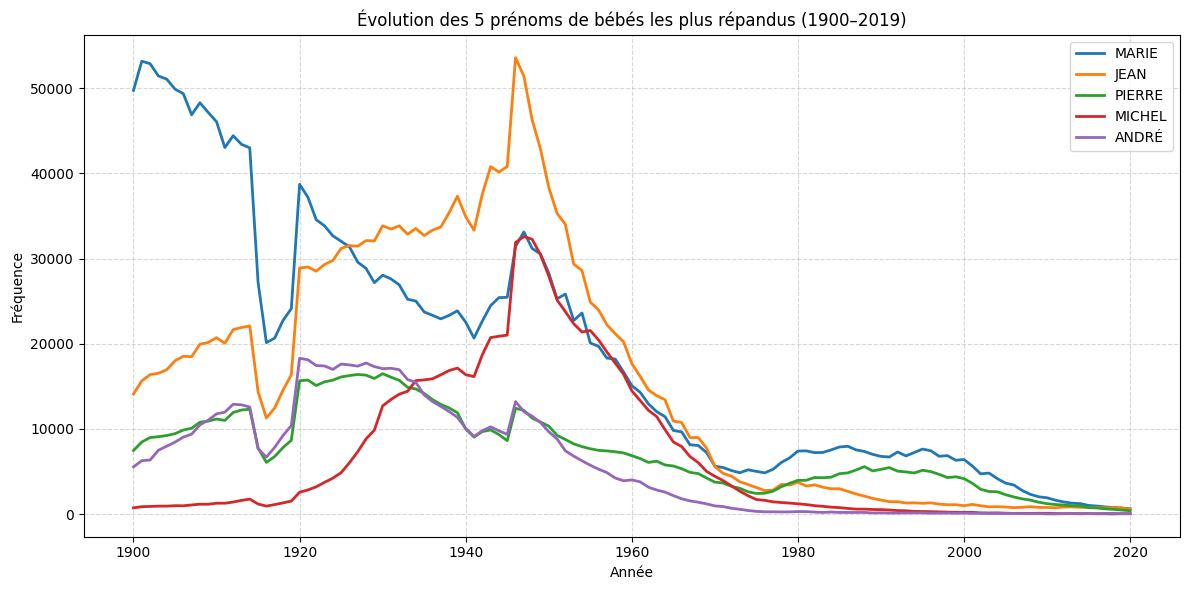

In [10]:
## Visualisation avec matplotlib
plt.figure(figsize=(12, 6))

for name in top_names:
    plt.plot(pivot_df.index, pivot_df[name], label=name, linewidth=2)

plt.title("Évolution des 5 prénoms de bébés les plus répandus (1900–2019)")
plt.xlabel("Année")
plt.ylabel("Fréquence")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Interpretation**

Le graphique montre l’évolution annuelle de la fréquence des 5 prénoms les plus donnés : Marie, Jean, Pierre, Michel, et André.

* Marie : Ce prénom féminin domine au début du XXe siècle avec des pics dépassant 50 000 naissances par an. Il subit un déclin progressif à partir des années 1950, malgré quelques remontées ponctuelles dans les années 80.

* Jean : Très populaire entre 1920 et 1960, avec un pic marqué autour de 1950. Sa fréquence chute rapidement à partir des années 60, probablement en raison d’un changement des tendances culturelles.

* Pierre et Michel : Ces prénoms masculins ont connu une croissance continue jusqu’aux années 50 avant de décliner nettement.

* André : Très courant dans les années 1920-40, il suit la même tendance de déclin que les autres prénoms masculins classiques.

__Après la visualisation statique, nous avons choisi d’ajouter une visualisation interactive à l’aide de la librairie Altair, pour :__

    permettre à l’utilisateur d’explorer dynamiquement les données,

    afficher des infobulles au survol contenant le prénom, l’année et le nombre de naissances,

    conserver une interface épurée et réactive malgré le volume de données important.

In [15]:
## Visualisation interactive avec Altair
alt.data_transformers.disable_max_rows()

long_df = pivot_df.reset_index().melt(id_vars='year', var_name='name', value_name='count')

chart = alt.Chart(long_df).mark_line().encode(
    x=alt.X('year:Q',axis=alt.Axis(format='d')),
    y='count:Q',
    color='name:N',
    tooltip=['name:N', 'year:Q', 'count:Q']
).properties(
    title="Évolution interactive des prénoms (1900–2019)",
    width=700,
    height=400
).interactive()

chart.show()

alt.Chart(...)

#### phase 2 : Visualisation 2 : évolution des prénoms d’enfant, géographiquement

**Objectif**
L’objectif de cette deuxième visualisation est de cartographier les prénoms les plus attribués par département sur l’ensemble de la période 1900–2020.
Cela permet d'explorer les spécificités régionales dans le choix des prénoms, et de voir si certaines régions présentent des préférences particulières.



**Méthodologie**

Voici les étapes de traitement des données :

* Le fichier GeoJSON contenant les contours des départements français est chargé avec geopandas.

* Les données sont agrégées par prénom et par département (groupby(['dpt', 'name'])), en calculant le total des naissances.

* Pour chaque département, on identifie le prénom le plus fréquent en sélectionnant la ligne avec la valeur maximale (idxmax).

* Enfin, les données sont fusionnées avec les géométries pour pouvoir afficher la carte.

In [16]:
geo_df = gpd.read_file("departements-version-simplifiee.geojson")
geo_df = geo_df.rename(columns={'code': 'dpt'})


In [17]:
# Regrouper toutes les naissances par prénom et département
top_names = df.groupby(['dpt', 'name'])['count'].sum().reset_index()

In [35]:
#version Julien (à valider ou pas)
top3_by_dept = (
    top_names.sort_values(['dpt', 'count'], ascending=[True, False])
    .groupby('dpt')
    .head(3)
)

# Concaténer les prénoms dans une seule chaîne de caractères par département
top3_concat = (
    top3_by_dept.groupby('dpt')['name']
    .apply(lambda x: ', '.join(x))
    .reset_index()
)

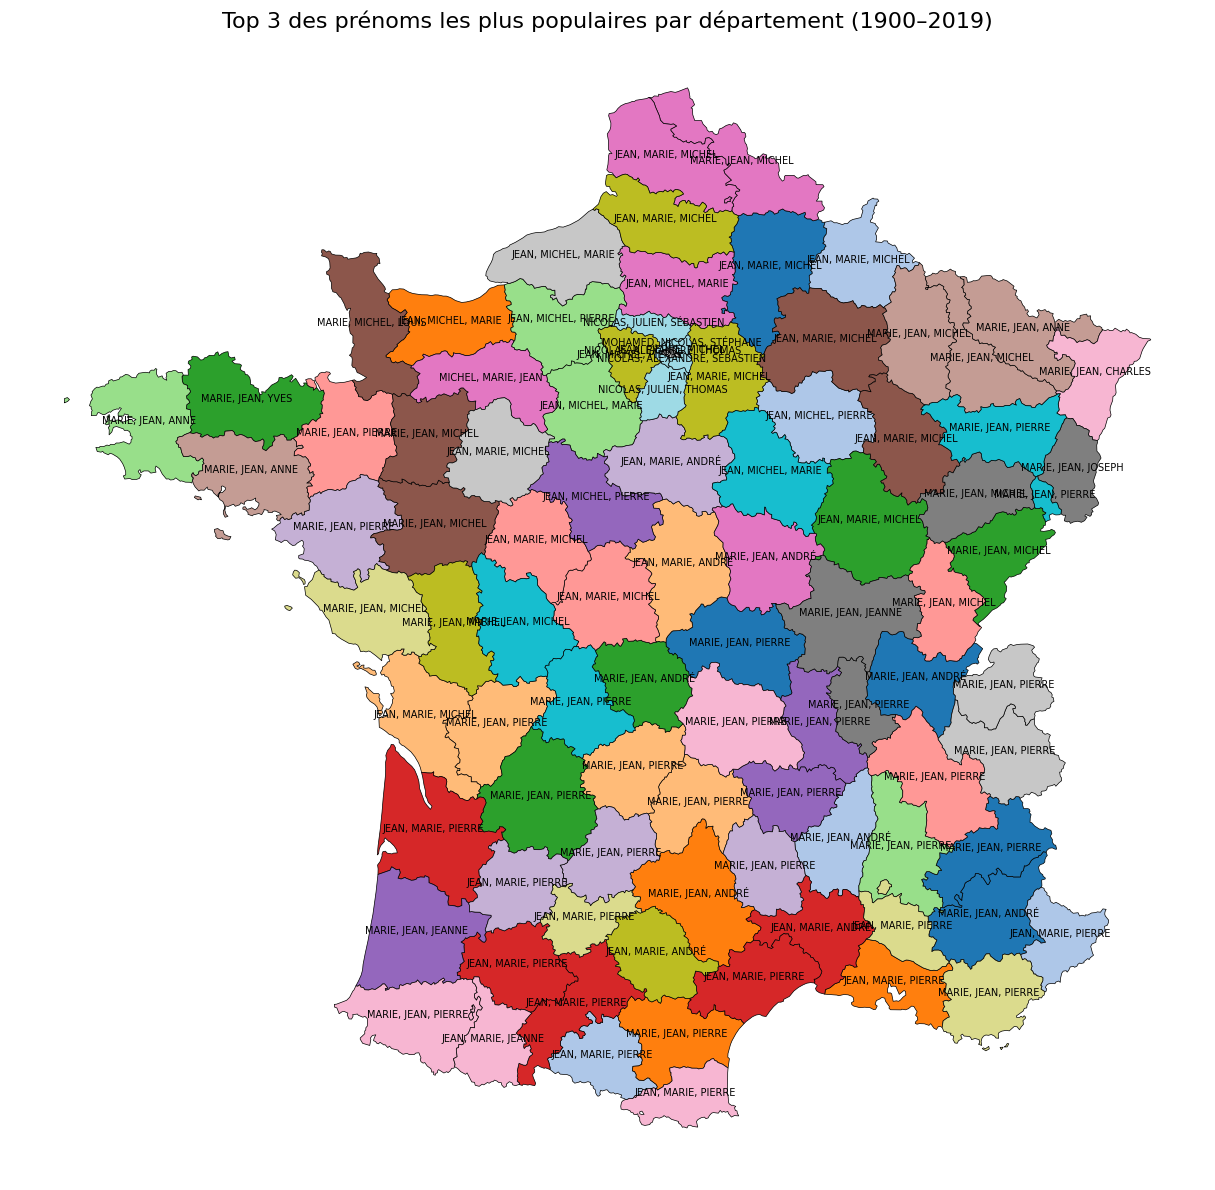

In [38]:
map_df = geo_df.merge(top3_concat, on='dpt')
# Générer une couleur unique par département
map_df['color_id'] = map_df['dpt'].astype('category').cat.codes
cmap = plt.get_cmap('tab20', map_df['color_id'].nunique())
fig, ax = plt.subplots(figsize=(15, 12))
map_df.plot(
    column='color_id',
    cmap=cmap,
    edgecolor='black',
    linewidth=0.5,
    ax=ax,
    legend=False
)
for idx, row in map_df.iterrows():
    if row['geometry'].centroid.is_empty:
        continue
    x, y = row['geometry'].centroid.coords[0]
    ax.annotate(
        row['name'],
        xy=(x, y),
        ha='center',
        fontsize=7,
        color='black'
    )

ax.set_title("Top 3 des prénoms les plus populaires par département (1900–2019)", fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()


In [18]:
#version Aymen/Nohalia
# Garder uniquement le prénom avec le max de naissances par département
idxmax = top_names.groupby('dpt')['count'].idxmax()
top_by_dept = top_names.loc[idxmax].reset_index(drop=True)

In [19]:
map_df = geo_df.merge(top_by_dept, on='dpt')

**Choix de visualisation**

Ce type de carte choroplèthe permet de :

* Visualiser l’influence géographique dans le choix des prénoms.

* Offrir une vue synthétique et esthétique des prénoms les plus emblématiques localement.

<Figure size 1500x1200 with 0 Axes>

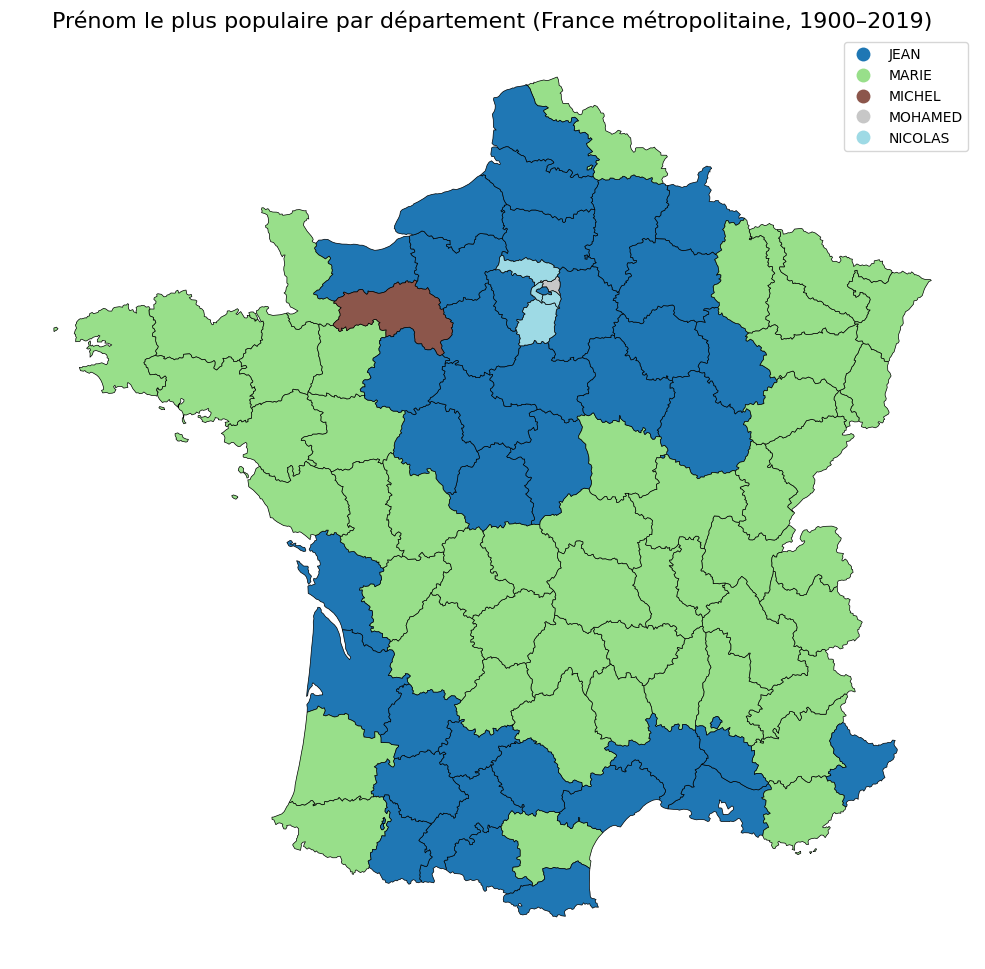

In [20]:
plt.figure(figsize=(15, 12))
map_df.plot(
    column='name',
    cmap='tab20',
    legend=True,
    edgecolor='black',
    linewidth=0.5,
    figsize=(15, 12)
)
plt.title("Prénom le plus populaire par département (France métropolitaine, 1900–2019)", fontsize=16)
plt.axis('off')
plt.show()

**Interpretation**

Cette carte présente, pour chaque département de France métropolitaine, le prénom qui a été le plus attribué sur la période 1900 à 2019. Elle permet d’identifier visuellement les dynamiques régionales dans la préférence des prénoms.

* La dominance de quelques prénoms classiques sur tout le territoire met en lumière le poids de la tradition dans le choix des prénoms.

* L’apparition ponctuelle de prénoms comme Mohamed ou Nicolas témoigne de changements sociétaux et de l'influence de l'immigration ou de la mode sur les prénoms, notamment dans les grandes agglomérations.

* Cette carte donne une lecture territoriale des prénoms et permet d'envisager des analyses plus fines par période, genre ou typologie culturelle.

##### Partie 2 – Focus sur un département (ex. Bouches-du-Rhône)

In [21]:
output = widgets.Output()

In [22]:
def on_dpt_change(change):
    """
    Cette fonction est appelée à chaque changement de sélection de département.

    change['new'] contient le code du département sélectionné.

    Les données sont filtrées pour ne conserver que celles correspondant à ce département (df_focus)"""
    with output:
        clear_output(wait=True)
        dpt_code = change['new']
        df_focus = df[df['dpt'] == dpt_code]

        if df_focus.empty:  #Si aucun enregistrement n’est trouvé pour le département, un message d'erreur s'affiche et on quitte la fonction.

            print(f"Aucune donnée pour le département {dpt_code}.")
            return

        """
    Les données sont agrégées par prénom (groupby('name')) puis triées par fréquence décroissante.

    On conserve uniquement les 5 prénoms les plus attribués dans ce département."""
        top_names_focus = (
            df_focus.groupby('name')['count']
            .sum()
            .sort_values(ascending=False)
            .head(5)
            .reset_index()
        )

        """
    On crée un diagramme à barres horizontal avec la librairie Altair :

    Axe X : le nombre de naissances

    Axe Y : le prénom

    Chaque barre est colorée selon le prénom (sans légende, car déjà visible sur l’axe)

    Le graphique est ensuite affiché dynamiquement dans l’output."""
        chart = alt.Chart(top_names_focus).mark_bar().encode(
            x=alt.X('count:Q', title='Fréquence'),
            y=alt.Y('name:N', sort='-x', title='Prénom'),
            color=alt.Color('name:N', legend=None)
        ).properties(
            title=f"Top 5 prénoms dans le département {dpt_code}",
            width=500,
            height=300
        )
        display(chart)

In [23]:
# Création du widget interactif
alt.data_transformers.disable_max_rows() #Désactive la limite par défaut du nombre de lignes dans les graphiques Altair, ce qui est nécessaire pour afficher des datasets volumineux.
"""
On extrait tous les codes de départements uniques présents dans le dataset.
Ils sont triés pour apparaître de manière lisible et ordonnée dans la liste déroulante.
"""
departements = sorted(df['dpt'].unique())
"""
Création d’un menu déroulant interactif (dropdown) contenant tous les départements.
Le département "13" (Bouches-du-Rhône) est sélectionné par défaut.
description ajoute un label explicatif à gauche du widget.
"""
dpt_dropdown = widgets.Dropdown(
    options=departements,
    value='13',
    description='Département :'
)
dpt_dropdown.observe(on_dpt_change, names='value')

display(dpt_dropdown, output)

# Affichage initial
on_dpt_change({'new': '13'})

Dropdown(description='Département :', index=12, options=('01', '02', '03', '04', '05', '06', '07', '08', '09',…

Output()

#### phase 3 : Visualisation 3 : évolution des prénoms d’enfant, en fonction du sexe

In [24]:
df["sex"] = df["sex"].map({1: "Fille", 2: "Garçon"})

""" On remplace les valeurs numériques par des étiquettes plus lisibles :
1 => "Fille"
2 => "Garçon"
Cela facilite la lecture des graphiques et l’interprétation des résultats.
"""

' On remplace les valeurs numériques par des étiquettes plus lisibles :\n1 => "Fille"\n2 => "Garçon"\nCela facilite la lecture des graphiques et l’interprétation des résultats.\n'

In [25]:
top4_filles = (
    df[df["sex"]=="Fille"].groupby("name")["count"].sum()
    .sort_values(ascending=False).head(4)
)

"""
On filtre les données pour les filles.
On regroupe par prénom et on somme le nombre total de naissances.
On trie du plus populaire au moins populaire.
On garde les 4 prénoms féminins les plus donnés.
"""

'\nOn filtre les données pour les filles.\nOn regroupe par prénom et on somme le nombre total de naissances.\nOn trie du plus populaire au moins populaire.\nOn garde les 4 prénoms féminins les plus donnés.\n'

In [26]:
#  Même logique pour les garçons  #
# Top 4 garçons
top4_garcons = (
    df[df["sex"]=="Garçon"].groupby("name")["count"].sum()
    .sort_values(ascending=False).head(4)
)

In [27]:
"""
On construit une liste combinée des 4 prénoms féminins + 4 prénoms masculins.
On extrait du dataset uniquement les lignes qui concernent ces prénoms pour les visualiser ensui
"""
selection_noms = top4_filles.index.tolist() + top4_garcons.index.tolist()
plot_df = df[df["name"].isin(selection_noms)]

In [28]:
chart = (
    alt.Chart(plot_df)
    .transform_aggregate(
        total="sum(count)", groupby=["name","sex"]
    )  # Altair agrège les données : on calcule le nombre total de naissances pour chaque couple (prénom, sexe) via sum(count).
    .mark_bar()
    .encode(
        #Chaque barre représente un prénom.
        #L’axe Y affiche le nombre total de naissances.
        #Les prénoms sont triés selon leur popularité (sort="-y").

        x=alt.X("name:N", title="Prénom", sort="-y"),
        y=alt.Y("total:Q", title="Total naissances 1900‑2020"),
        color=alt.Color("sex:N", scale=alt.Scale(domain=["Fille","Garçon"], range=["orange","hotpink"]), title="Sex"),
        #Les couleurs permettent de différencier filles et garçons.
        #Un tooltip interactif permet de consulter les détails au survol.
        tooltip=["name:N","sex:N","total:Q"]
    )
    .properties(width=500, height=400, title="Top 4 prénoms par sexe")
)
chart

alt.Chart(...)

**Interpretation**

* Ce graphique montre un écart de distribution important entre le prénom dominant (Marie) et les autres, révélant une forte préférence culturelle pour ce prénom dans le passé.

* La présence des prénoms comme Jean, Pierre, Michel reflète l’usage de prénoms bibliques ou traditionnels pendant le XXe siècle.

* Le fait que les prénoms féminins soient globalement moins diversifiés et plus concentrés est une tendance que l’on pourrait approfondir.

In [29]:
#Cette étape assure une agrégation explicite dans Altair, même si elle a déjà été faite avec groupby (par sécurité/cohérence avec Altair).

evo2 = plot_df.groupby(["year","name","sex"])["count"].sum().reset_index()

In [34]:
chart_evo = (
    alt.Chart(evo2)
    .transform_aggregate(
        total="sum(count)",
        groupby=["year", "name", "sex"]
    )
    .mark_line()
    .encode(

    #"""Chaque ligne représente un prénom.
    #Les lignes sont différenciées par sexe grâce au style strokeDash :
        #Pointillés pour les filles
        #Lignes continues pour les garçons
    #Le tooltip donne des infos interactives survolées : prénom, sexe, année, total."""

        x=alt.X("year:Q",axis=alt.Axis(format='d'),title="Année"),
        y=alt.Y("total:Q", title="Naissances annuelles"),
        color=alt.Color("name:N", title="Prénom"),
        strokeDash=alt.StrokeDash("sex:N", scale=alt.Scale(domain=["Fille", "Garçon"], range=[[5,5], [1,0]]), title="Sexe"),
        tooltip=["name:N", "sex:N", "year:Q", "total:Q"]
    )
    .properties(
        width=700,
        height=400,
        title="Évolution des 4 prénoms les plus populaires par sexe (1900–2020)"
    )
)

chart_evo


alt.Chart(...)

**Interpretation**

Ce graphique permet de visualiser, année par année, la popularité des prénoms les plus donnés aux filles et garçons.

* Le style en courbes temporelles permet de détecter les phénomènes générationnels.

* L’usage de lignes pleines vs pointillées donne une lecture très intuitive du genre associé à chaque prénom.

* On constate une baisse marquée de l’usage des prénoms classiques dans les années 2000–2020, traduisant une diversification culturelle et un attrait pour la nouveauté.